# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

***Заказчик этого исследования*** — сеть отелей «Как в гостях».<br>
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.<br>
***Задача:*** Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.<br>
   
***Стоимость номеров отеля:***
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.<br>
   
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.<br>
На разработку системы прогнозирования заложен бюджет — ***400 000***. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Шаг 1. Откройте файлы с данными

In [643]:
# установка pandas-profiling
!pip install pandas-profiling

In [644]:
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [645]:
data_train = pd.read_csv('hotel_train.csv') 

In [646]:
data_train.head()

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0   0            0        7.0               2015               July   
1   1            0       14.0               2015               July   
2   2            0        0.0               2015               July   
3   3            0        9.0               2015               July   
4   4            1       85.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     1     1.0  ...   
1                        0                     2     2.0  ...   
2                        0                     2     2.0  ...   
3                        0                     2     2.0  ...   
4                        0                     3     2.0  ...   

   is_repeated_guest  previous_cancellations previous_bookings_not_canceled  \
0                  0                       0                              0   
1                  0                       0                              0   
2                  0                       0                              0   
3                  0                       0                              0   
4                  0                       0                              0   

  reserved_room_type booking_changes  days_in_waiting_list  customer_type  \
0   A                              0                     0      Transient   
1   A                              0                     0      Transient   
2   C                              0                     0      Transient   
3   C                              0                     0      Transient   
4   A                              0                     0      Transient   

   required_car_parking_spaces total_of_special_requests  total_nights  
0                            0                         0             1  
1                            0                         1             2  
2                            0                         0             2  
3                            0                         1             2  
4                            0                         1             3  

[5 rows x 25 columns]

In [647]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [648]:
data_test = pd.read_csv('hotel_test.csv') 

In [649]:
data_test.head()

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  6086            1       74.0               2017            January   
1  6087            1       62.0               2017            January   
2  6088            1       62.0               2017            January   
3  6089            1       71.0               2017            January   
4  6090            1      172.0               2017            January   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         1                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         1                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        1                     0     2.0  ...   
1                        2                     2     2.0  ...   
2                        2                     2     2.0  ...   
3                        2                     2     1.0  ...   
4                        2                     5     2.0  ...   

   is_repeated_guest  previous_cancellations previous_bookings_not_canceled  \
0                  0                       0                              0   
1                  0                       0                              0   
2                  0                       0                              0   
3                  0                       0                              0   
4                  0                       0                              0   

  reserved_room_type booking_changes  days_in_waiting_list  customer_type  \
0   A                              0                     0      Transient   
1   A                              0                     0      Transient   
2   A                              0                     0      Transient   
3   A                              0                     0      Transient   
4   A                              0                     0      Transient   

   required_car_parking_spaces total_of_special_requests  total_nights  
0                            0                         0             1  
1                            0                         1             4  
2                            0                         1             4  
3                            0                         1             4  
4                            0                         0             7  

[5 rows x 25 columns]

In [650]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

### Шаг 2. Предобработка и исследовательский анализ данных

#### Исследование обучающей выборки

In [651]:
# инфо об обучающей выборке
data_train_profile = pandas_profiling.ProfileReport(data_train) 
data_train_profile.to_file("data_train_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

`is_canceled` - целевая переменная, объектов отрицательного класса значительно больше.<br>
Переменная по своей сущности относится к булеву типу данных.

In [652]:
data_train.query('is_canceled == 0')['id'].count() / data_train.shape[0]

0.6313909457449908

63% объектов отрицательного класса.

`lead_time` — количество дней между датой бронирования и датой прибытия<br>
Минимум: 0 - это 5.2% значений. Означает, что номер заранее не бронировали.<br>
Максимум: 374<br>
Среднее: 96

`arrival_date_year` — год заезда<br>
В выборке только два года: 2015 и 2016. 2016 значительно больше.

In [653]:
data_train.query('arrival_date_year == 2016')['id'].count() / data_train.shape[0]

0.7190206809854512

Почти 72% наблюдений - это 2016 год.

`arrival_date_month` — месяц заезда;<br>
В выборке есть данные за весь год.  Наиболее популярные месяцы - сентябрь и октябрь.

`arrival_date_week_number` — неделя заезда<br>
По своей сути это категориальная переменная, а не числовая. В выборке есть данные по всем неделям от 1 до 53.

In [654]:
data_train['arrival_date_week_number'].value_counts()

42    2360
38    2318
41    2238
39    2166
40    1984
43    1883
37    1869
44    1819
33    1748
36    1734
45    1642
53    1502
49    1454
32    1444
30    1442
34    1440
47    1419
35    1413
29    1355
46    1324
25    1322
48    1297
50    1256
27    1253
18    1212
17    1208
21    1208
28    1190
31    1170
13    1155
23    1146
15    1137
24    1065
20    1062
16    1060
19     960
22     943
52     928
26     920
8      893
10     890
12     889
14     878
9      847
7      805
11     787
51     753
6      575
4      485
5      485
3      359
2      335
1      202
Name: arrival_date_week_number, dtype: int64

Чаще всего встречаются 38 и 42 недели - это как раз сентябрь-октябрь.

`arrival_date_day_of_month` — день заезда<br>
Здесь представлены числа месяца от 1 до 31. Особо выделяющихся значений по частоте нет.

`stays_in_weekend_nights` — количество ночей в выходные дни<br>
Значения от 0 до 4. Нулевых значений больше всего - значит, гостиницу чаще бронируют на будние дни.

In [655]:
data_train.query('stays_in_weekend_nights == 0')['id'].count() / data_train.shape[0]

0.45590151619678365

Нулевых значений - почти половина выборки.

`stays_in_week_nights` — количество ночей в будние дни<br>
Значения от 0 до 6. 6% нулевых значений - это, скорей всего, те, кто бронировал только выходные.<br>
Самые частотные значения: 1-2 ночи в будние.

`adults` — количество взрослых постояльцев<br>
Значения от 0 до 4.<br>
Самое частотное значение - 2 взрослых постояльца.<br>
Нулевые значения в этой колонке выглядят странно.

In [656]:
data_train.query('adults == 0')

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
17540  25480            0        1.0               2015             August   
17598  25538            0      104.0               2015             August   
17982  25922            0        3.0               2015             August   
21556  29496            1       48.0               2015            October   
22516  30456            1        6.0               2015           December   
...      ...          ...        ...                ...                ...   
64751  83478            0      197.0               2016           December   
64882  83610            0      104.0               2016           December   
64892  83620            0      104.0               2016           December   
64903  83633            0      247.0               2016           December   
64980  83710            0      255.0               2016           December   

       arrival_date_week_number  arrival_date_day_of_month  \
17540                        33                         10   
17598                        33                         11   
17982                        34                         16   
21556                        43                         19   
22516                        51                         13   
...                         ...                        ...   
64751                        52                         21   
64882                        53                         25   
64892                        53                         25   
64903                        52                         24   
64980                        53                         27   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
17540                        1                     1     0.0  ...   
17598                        0                     3     0.0  ...   
17982                        2                     0     0.0  ...   
21556                        1                     3     0.0  ...   
22516                        1                     0     0.0  ...   
...                        ...                   ...     ...  ...   
64751                        1                     4     0.0  ...   
64882                        2                     1     0.0  ...   
64892                        2                     1     0.0  ...   
64903                        2                     3     0.0  ...   
64980                        0                     3     0.0  ...   

       is_repeated_guest  previous_cancellations  \
17540                  0                       0   
17598                  0                       0   
17982                  0                       0   
21556                  0                       0   
22516                  0                       0   
...                  ...                     ...   
64751                  0                       0   
64882                  0                       0   
64892                  0                       0   
64903                  0                       0   
64980                  0                       0   

      previous_bookings_not_canceled reserved_room_type booking_changes  \
17540                              0   B                              1   
17598                              0   B                              1   
17982                              0   B                              1   
21556                              0   B                              0   
22516                              0   B                              0   
...                              ...                ...             ...   
64751                              0   A                              7   
64882                              0   B                              1   
64892                              0   B                              0   
64903                              0   B                              0   
64980                              0   A         

Проверим, есть ли номера, в которых вообще нет постояльцев.

In [657]:
data_train.query('adults == 0 and children == 0 and babies == 0')

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
23770  31710            0       48.0               2016           February   
26878  34818            0      122.0               2016                May   
26879  34819            0      122.0               2016                May   
31570  39510            0      256.0               2016             August   
41461  59858            0        0.0               2015           November   
50744  69262            0       52.0               2016              April   
54881  73467            0      108.0               2016               July   
56674  75308            0        4.0               2016             August   
57390  76028            0       88.0               2016             August   
58416  77078            0       36.0               2016             August   
62781  81483            0       57.0               2016           November   
62783  81485            0       74.0               2016           November   
63311  82015            0       37.0               2016           November   
63360  82064            0        1.0               2016           November   
64980  83710            0      255.0               2016           December   

       arrival_date_week_number  arrival_date_day_of_month  \
23770                         9                         21   
26878                        19                          5   
26879                        19                          5   
31570                        35                         21   
41461                        49                         30   
50744                        18                         30   
54881                        28                          5   
56674                        32                          5   
57390                        34                         16   
58416                        35                         27   
62781                        46                          9   
62783                        46                          7   
63311                        47                         17   
63360                        47                         18   
64980                        53                         27   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
23770                        2                     4     0.0  ...   
26878                        2                     4     0.0  ...   
26879                        2                     4     0.0  ...   
31570                        3                     5     0.0  ...   
41461                        1                     2     0.0  ...   
50744                        2                     4     0.0  ...   
54881                        2                     5     0.0  ...   
56674                        2                     2     0.0  ...   
57390                        0                     4     0.0  ...   
58416                        3                     6     0.0  ...   
62781                        0                     2     0.0  ...   
62783                        1                     3     0.0  ...   
63311                        1                     3     0.0  ...   
63360                        1                     2     0.0  ...   
64980                        0                     3     0.0  ...   

       is_repeated_guest  previous_cancellations  \
23770                  0                       0   
26878                  0                       0   
26879                  0                       0   
31570                  0                       0   
41461                  1                       0   
50744                  0                       0   
54881                  0                       0   
56674                  0                       0   
57390                  0                       0   
58416                  0                       0   
62781                  0                       0   
62783                  0               

Скорей всего, это аномалии, т.к. номер без постояльцев быть не может и детям без взрослых сдать номер тоже не могут, поэтому можем удалить эти строки.

In [658]:
data_train = data_train.query('adults != 0')

`children` — количество детей от 3 до 14 лет<br>
Значения от 0 до 3. Постояльцев без детей большинство.

In [659]:
data_train.query('children == 0')['id'].count() / data_train.shape[0]

0.9482655272581959

А именно - 94% постояльцев приезжают без детей.

`babies` — количество младенцев<br>
В основном, постояльцы приезжают и без младенцев тоже.

In [660]:
data_train['babies'].value_counts()

0.0     64614
1.0       444
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

In [661]:
data_train.query('babies == 0')['id'].count() / data_train.shape[0]

0.9930989963573768

99% постояльцев без младенцев. А вот 9 и 10 младенцев выглядит странно.

In [662]:
data_train.query('babies == 9 | babies == 10')

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
22995  30935            0       37.0               2016            January   
41528  59925            0       11.0               2015            October   

       arrival_date_week_number  arrival_date_day_of_month  \
22995                         3                         12   
41528                        42                         11   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
22995                        0                     2     2.0  ...   
41528                        2                     1     1.0  ...   

       is_repeated_guest  previous_cancellations  \
22995                  0                       0   
41528                  0                       0   

      previous_bookings_not_canceled reserved_room_type booking_changes  \
22995                              0   D                              1   
41528                              0   A                              1   

       days_in_waiting_list    customer_type  required_car_parking_spaces  \
22995                     0        Transient                            0   
41528                     0  Transient-Party                            0   

      total_of_special_requests  total_nights  
22995                         1             2  
41528                         0             3  

[2 rows x 25 columns]

Всего 2 подобных строки - это аномалии и их можно удалить.

In [663]:
data_train = data_train.query('babies <= 2')

Постояльцев в двумя младенцами всего 3, поэтому можно преобразовать признак таким образом, чтобы он только показывал, есть ли младенцы или нет, без указания их количества.

In [664]:
data_train.loc[data_train['babies'] > 1, 'babies'] = 1

In [665]:
data_train['babies'].value_counts()

0.0    64614
1.0      447
Name: babies, dtype: int64

Т.к. признак из количественного преобразован в бинарный, дадим ему соответствующее название.

In [666]:
data_train.rename(columns={"babies": "has_babies"}, inplace=True)

In [667]:
data_train.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'has_babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

`meal` — опции заказа:
- SC — нет дополнительных опций;
- BB — включён завтрак;
- HB — включён завтрак и обед;
- FB — включён завтрак, обед и ужин.<br>
У большинства постояльцев включён только завтрак.

In [668]:
data_train.query('meal == "BB"')['id'].count() / data_train.shape[0]

0.0

Получили странный результат. Проверим, как записаны значения в столбце.

In [669]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

В значениях появились лишние пробелы, можем их удалить.

In [670]:
data_train['meal'].value_counts()

BB           51544
HB            7289
SC            5262
SC             515
FB             451
Name: meal, dtype: int64

In [671]:
data_train['meal'] = data_train['meal'].apply(lambda x: x.strip())

In [672]:
data_train.query('meal == "BB"')['id'].count() / data_train.shape[0]

0.7922411275572155

Итак, 79% постояльцев заказывают только завтрак.

In [673]:
data_train['meal'].value_counts()

BB    51544
HB     7289
SC     5777
FB      451
Name: meal, dtype: int64

`country` — гражданство постояльца<br>
Всего в выборке 155 стран. Больше всего постояльцев из Португалии.

In [674]:
data_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [675]:
data_train.query('country == "PRT"')['id'].count() / data_train.shape[0]

0.44250780037195864

44% постояльцев из Португалии - это почти половина.

155 стран это очень много, можем оставить только топ-30, а остальным присвоить категорию Other.

In [676]:
top_countries = data_train['country'].value_counts().head(30).index.tolist()

In [677]:
rows = ~data_train['country'].isin(top_countries)

In [678]:
data_train.loc[rows, 'country'] = 'Other'

In [679]:
data_train['country'].value_counts()

PRT      28790
FRA       5958
GBR       5095
ESP       4887
DEU       3879
ITA       2319
Other     1964
IRL       1442
BEL       1231
NLD       1159
BRA       1083
USA       1005
CHE        866
AUT        715
SWE        541
POL        529
CHN        525
CN         488
ISR        375
RUS        293
NOR        261
ROU        247
FIN        239
DNK        200
TUR        168
AUS        168
AGO        140
LUX        133
MAR        123
HUN        121
JPN        117
Name: country, dtype: int64

`distribution_channel` — канал дистрибуции заказа<br>
- TA/TO - турагенство/туроператор
- Direct - прямой канал
- Corporate - корпоративный канал
- GDS - глобальная дистрибьюторская система
Чаще всего гостиницу бронируют через тураегенство.

In [680]:
data_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [681]:
data_train.query('distribution_channel == "TA/TO"')['id'].count() / data_train.shape[0]

0.8347550760055947

83% - бронь через турагенства.

`is_repeated_guest` — признак того, что гость бронирует номер второй раз<br>
Большинство гостей бронируют номер впервые.

In [682]:
data_train.query('is_repeated_guest == 1')['id'].count() / data_train.shape[0]

0.027205238161110343

Только 2.7% постояльцев пользуются услугами гостиницы уже не в первый раз.

`previous_cancellations` — количество отменённых заказов у клиента<br>
91.4% нулевых значений - т.е. отменённых заказов у клиентов не было.<br>
Максимальное значение: 26

In [683]:
data_train['previous_cancellations'].value_counts()

0     59424
1      5366
2        54
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64

`previous_bookings_not_canceled` — количество подтверждённых заказов у клиента<br>
97.6% нулевых значений - эта колонка по смыслу дублирует колонку `is_repested_guest`.<br>
Максимальное значение: 58<br>
Две колонки, похожие по смыслу, не нужны, поэтому оставим только `is_repeated_guest`, а эту удалим.

In [684]:
data_train = data_train.drop(columns=['previous_bookings_not_canceled'])

`reserved_room_type` — тип забронированной комнаты<br>
Значения по алфавиту от A до G. Тип А - самый распространённый.

In [685]:
data_train.query('reserved_room_type == "A"')['id'].count() / data_train.shape[0]

0.0

In [686]:
data_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [687]:
# удалим лишние пробелы
data_train['reserved_room_type'] = data_train['reserved_room_type'].apply(lambda x: x.strip())

In [688]:
data_train.query('reserved_room_type == "A"')['id'].count() / data_train.shape[0]

0.7759948356158067

77% постояльцев выбирают тип А.

`booking_changes` — количество изменений параметров заказа<br>
86.2% постояльцев не меняют параметры своего заказа.<br>
Максимальное значение: 17

`days_in_waiting_list` — сколько дней заказ ожидал подтверждения<br>
95.1% нулевых значений - заказ был подвтерждён в день брони.<br>
Максимальное значение: 259 - видимо, были какие-то сбои

`customer_type` — тип заказчика:
- Contract — договор с юридическим лицом;
- Group — групповой заезд;
- Transient — не связано с договором или групповым заездом;
- Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.<br>
Transient - самый распространённый тип

In [689]:
data_train.query('customer_type == "Transient"')['id'].count() / data_train.shape[0]

0.6978220439280061

Почти 70% заездов типа Transient.

`required_car_parking_spaces` — необходимость места для автомобиля<br>
Значения от 0 до 3. Больше всего нулевых значений - люди приезжают без машин.

`total_of_special_requests` — количество специальных отметок<br>
Значения от 0 до 5. 62.4% нулевых значений.

`total_nights` — общее количество ночей<br>
Значения от 1 до 10.<br>
Среднее значение: 3<br>
Эта колонка включает в себя `stays_in_weekend_nights` и `stays_in_week_nights` - можно оставить только её, удалив две предыдущие.

In [690]:
data_train.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'], inplace=True)

#### Исследование тестовой выборки

In [691]:
# инфо о тестовой выборке
data_test_profile = pandas_profiling.ProfileReport(data_test)
data_test_profile.to_file("data_test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

`is_canceled` - одинаковое соотношение объектов отрицательного и положительного классов.<br>
`lead_time` - распределение значений идентично.<br>
`arrival_date_year` - данные в тестовой выборке только за 2017 год, колонка вычеркнута из тестовой выборки.<br>
`arrival_date_month` - данные есть только за 8 месяцев. Соответственно, нет сентября, октября, ноября и декабря. Без их учёта самым популярным месяцем является май. <br>
`arrival_date_week_number` - пик приходится примерно на апрель. <br>
`arrival_date_day_of_month` - распределение идентично.<br>
`stays_in_weekend_nights` - распределение идентично. Колонку удаляем.<br>
`stays_in_week_nights` - распределение идентично. Колонку удаляем.<br>
`adults` -  распределение идентично. Нулевые значения в тестовой выборке тоже есть, значит, нужно избавиться от аномалий.<br>
`children` - распределение идентично.<br>
`babies` - в обучающей выборке были значения 9 и 10 младенцев, в тестовой значения только от 0 до 2. Колонку так же надо преобразовать в бинарный признак<br>
`meal` -  распределение идентично.<br>
`country` - в обучающей выборке 155 стран, в тестовой 143. В топе находятся одинаковые страны. Так же нужно оставить только топ-30 стран, остальным присвоить категорию Other<br>
`distribution_channel` - распределение идентично.<br>
`is_repeated_guest` - распределение идентично.<br>
`previous_cancellations` - распределение идентично.<br>
`previous_bookings_not_canceled` - распределение идентично. Колонку нужно удалить.<br>
`reserved_room_type` - распределение идентично.<br>
`booking_changes` - распределение идентично.<br>
`days_in_waiting_list` - распределение идентично.<br>
`customer_type` - распределение идентично.<br>
`required_car_parking_spaces` - распределение идентично.<br>
`total_of_special_requests` - распределение идентично.<br>
`total_nights` - распределение идентично.

In [692]:
data_test.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'], inplace=True)

In [693]:
data_test = data_test.query('adults != 0')

In [694]:
data_test.loc[data_test['babies'] > 1, 'babies'] = 1

In [695]:
data_test.rename(columns={'babies': 'has_babies'}, inplace=True)

In [696]:
data_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

Как и в обучающей выборке появились лишние пробелы, можем их удалить.

In [697]:
data_test['meal'] = data_test['meal'].apply(lambda x: x.strip())

In [698]:
data_test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

In [699]:
rows = ~data_test['country'].isin(top_countries)

In [700]:
data_test.loc[rows, 'country'] = 'Other'

In [701]:
data_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

In [702]:
# удалим лишние пробелы
data_test['reserved_room_type'] = data_test['reserved_room_type'].apply(lambda x: x.strip())

In [703]:
data_test.drop(columns=['previous_bookings_not_canceled'], inplace=True)

Колонку `arrival_date_year` нужно удалить из обеих выборок.

In [704]:
data_train = data_train.drop(columns=['arrival_date_year'])

In [705]:
data_test = data_test.drop(columns=['arrival_date_year'])

In [706]:
# проверим типы данных
data_train.dtypes

id                               int64
is_canceled                      int64
lead_time                      float64
arrival_date_month              object
arrival_date_week_number         int64
arrival_date_day_of_month        int64
adults                         float64
children                       float64
has_babies                     float64
meal                            object
country                         object
distribution_channel            object
is_repeated_guest                int64
previous_cancellations           int64
reserved_room_type              object
booking_changes                  int64
days_in_waiting_list             int64
customer_type                   object
required_car_parking_spaces      int64
total_of_special_requests        int64
total_nights                     int64
dtype: object

Для обучения модели не понадобится id, поэтому его можно удалить.

In [707]:
data_train.drop(columns=['id'], inplace=True)

Проверим наличие дубликатов после удаления идентификатора.

In [708]:
data_train[data_train.duplicated()]

is_canceled  lead_time arrival_date_month  arrival_date_week_number  \
13               0       72.0               July                        27   
85               1        5.0               July                        28   
115              0        0.0               July                        28   
127              1        1.0               July                        28   
219              0       40.0               July                        29   
...            ...        ...                ...                       ...   
65188            0      269.0           December                        53   
65189            0      269.0           December                        53   
65192            0      269.0           December                        53   
65193            0      269.0           December                        53   
65202            0      291.0           December                        53   

       arrival_date_day_of_month  adults  children  has_babies meal country  \
13                             1     2.0       0.0         0.0   BB     PRT   
85                             5     2.0       0.0         0.0   BB     PRT   
115                            7     1.0       0.0         0.0   BB     GBR   
127                            8     2.0       0.0         0.0   BB     PRT   
219                           13     2.0       0.0         0.0   BB     ESP   
...                          ...     ...       ...         ...  ...     ...   
65188                         29     1.0       0.0         0.0   BB     SWE   
65189                         29     1.0       0.0         0.0   BB     SWE   
65192                         29     1.0       0.0         0.0   BB     SWE   
65193                         29     1.0       0.0         0.0   BB     SWE   
65202                         28     2.0       0.0         0.0   BB     SWE   

      distribution_channel  is_repeated_guest  previous_cancellations  \
13                  Direct                  0                       0   
85                   TA/TO                  0                       0   
115                  TA/TO                  0                       0   
127              Corporate                  0                       0   
219                 Direct                  0                       0   
...                    ...                ...                     ...   
65188                TA/TO                  0                       0   
65189                TA/TO                  0                       0   
65192                TA/TO                  0                       0   
65193                TA/TO                  0                       0   
65202                TA/TO                  0                       0   

      reserved_room_type  booking_changes  days_in_waiting_list  \
13                     A                1                     0   
85                     D                0                     0   
115                    A                0                     0   
127                    A                0                     0   
219                    D                0                     0   
...                  ...              ...                   ...   
65188                  A                0                     0   
65189                  A                0                     0   
65192                  A                0                     0   
65193                  A                0                     0   
65202                  A                2                     0   

         customer_type  required_car_parking_spaces  \
13           Transient                            0   
85           Transient                            0   
115          Transient                            0   
127          Transient                            0   
219          Transient                            0   
...                ...                          ...   
65188  Transient-Party                            0   

In [709]:
data_train.duplicated().sum()

21494

Дубликаты для обучения модели не нужны, поэтому удалим их.

In [710]:
data_train = data_train.drop_duplicates()

In [711]:
data_test = data_test.drop(columns=['id'])

Проверим дубликаты в тестовой выборке тоже.

In [712]:
data_test.duplicated().sum()

7738

Удаление дубликатов из тестовой выборки приводит к ухудшению качества модели, поэтому их оставляем.

#### Визуализация данных

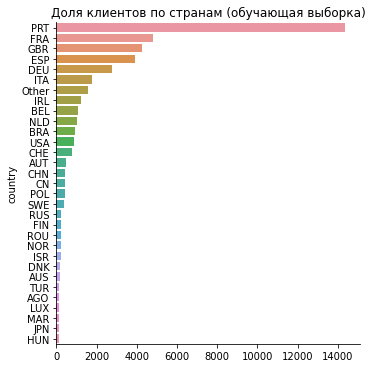

In [713]:
sns.catplot(
    data=data_train, 
    x=data_train.groupby('country')['country'].count().sort_values(ascending=False).values, 
    y=data_train.groupby('country')['country'].count().sort_values(ascending=False).index, 
    kind="bar",)   
plt.title('Доля клиентов по странам (обучающая выборка)')
plt.show()

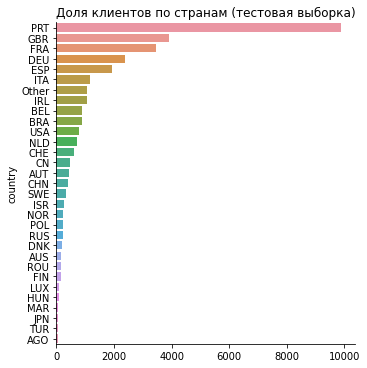

In [714]:
sns.catplot(
    data=data_test, 
    x=data_test.groupby('country')['country'].count().sort_values(ascending=False).values, 
    y=data_test.groupby('country')['country'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по странам (тестовая выборка)')
plt.show()

В обеих  выборках большинство постояльцев из европейских стран: Португалия, Великобритания, Франция, Германия, Испания, Италия.

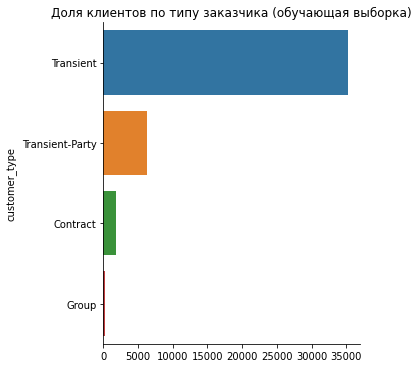

In [715]:
sns.catplot(
    data=data_train, 
    x=data_train.groupby('customer_type')['customer_type'].count().sort_values(ascending=False).values, 
    y=data_train.groupby('customer_type')['customer_type'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по типу заказчика (обучающая выборка)')
plt.show()

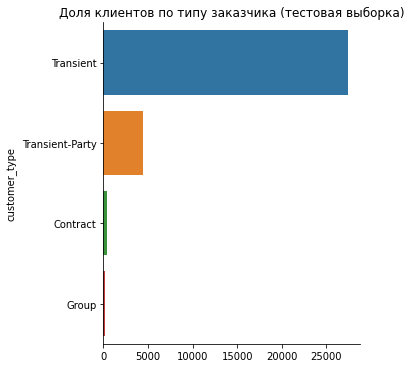

In [716]:
sns.catplot(
    data=data_test, 
    x=data_test.groupby('customer_type')['customer_type'].count().sort_values(ascending=False).values, 
    y=data_test.groupby('customer_type')['customer_type'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по типу заказчика (тестовая выборка)')
plt.show()

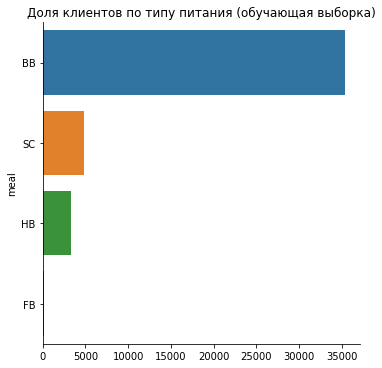

In [717]:
sns.catplot(
    data=data_train, 
    x=data_train.groupby('meal')['meal'].count().sort_values(ascending=False).values, 
    y=data_train.groupby('meal')['meal'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по типу питания (обучающая выборка)')
plt.show()

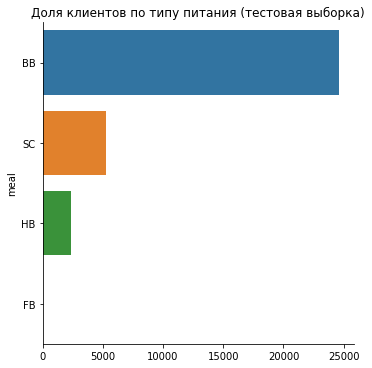

In [718]:
sns.catplot(
    data=data_test, 
    x=data_test.groupby('meal')['meal'].count().sort_values(ascending=False).values, 
    y=data_test.groupby('meal')['meal'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по типу питания (тестовая выборка)')
plt.show()

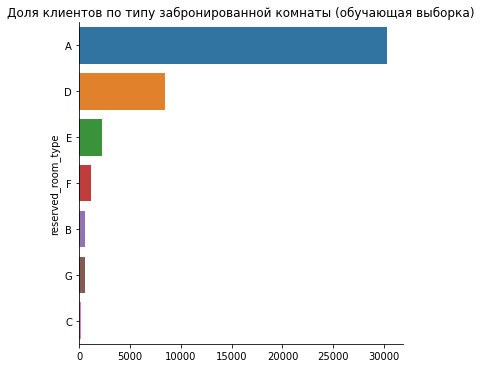

In [719]:
sns.catplot(
    data=data_train, 
    x=data_train.groupby('reserved_room_type')['reserved_room_type'].count().sort_values(ascending=False).values, 
    y=data_train.groupby('reserved_room_type')['reserved_room_type'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по типу забронированной комнаты (обучающая выборка)')
plt.show()

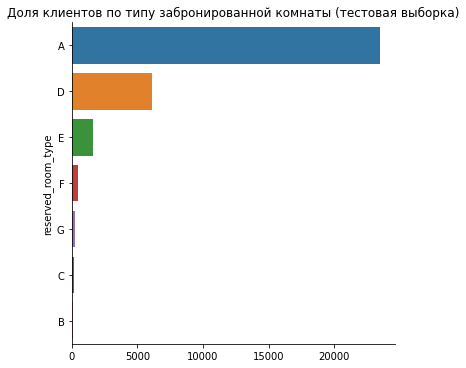

In [720]:
sns.catplot(
    data=data_test, 
    x=data_test.groupby('reserved_room_type')['reserved_room_type'].count().sort_values(ascending=False).values, 
    y=data_test.groupby('reserved_room_type')['reserved_room_type'].count().sort_values(ascending=False).index, 
    kind="bar")      
plt.title('Доля клиентов по типу забронированной комнаты (тестовая выборка)')
plt.show()

In [721]:
categorical = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type', 'has_babies', 'is_repeated_guest',
              ]
categorical

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type',
 'has_babies',
 'is_repeated_guest']

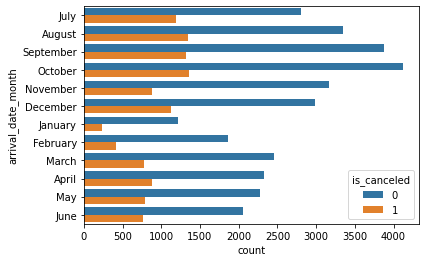

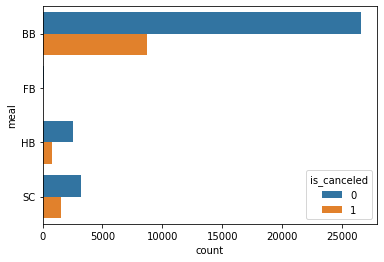

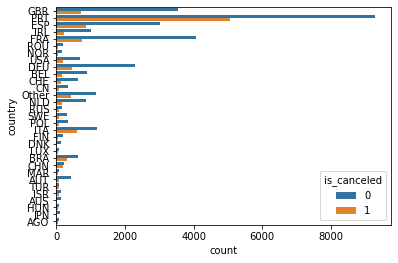

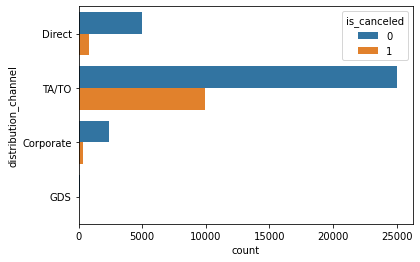

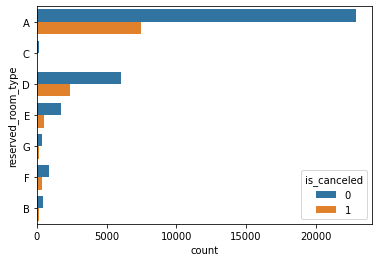

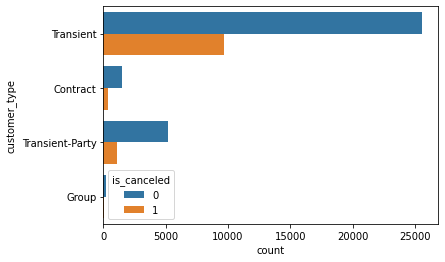

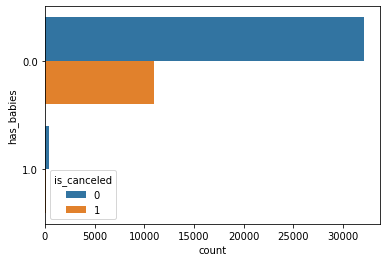

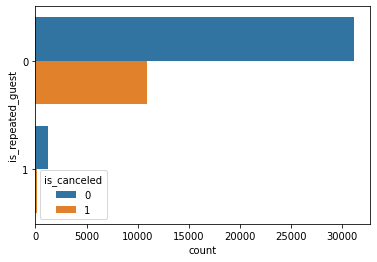

In [722]:
for item in categorical:
    sns.countplot(data = data_train,
                  hue ='is_canceled',
                  y = item)
    plt.show()

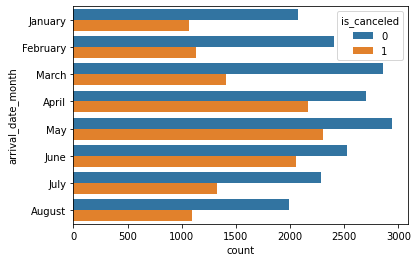

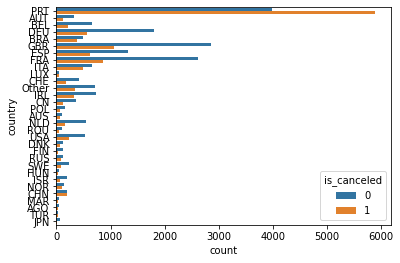

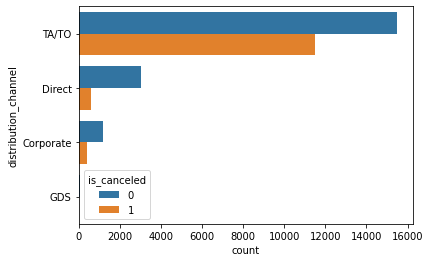

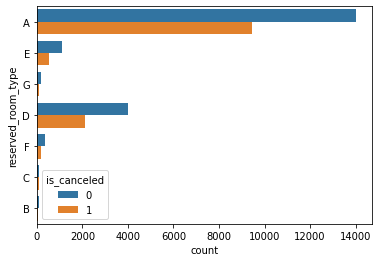

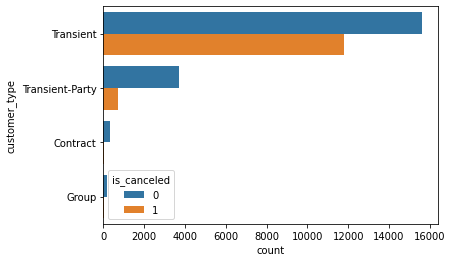

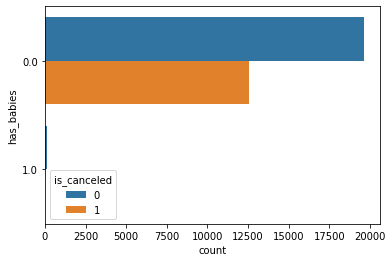

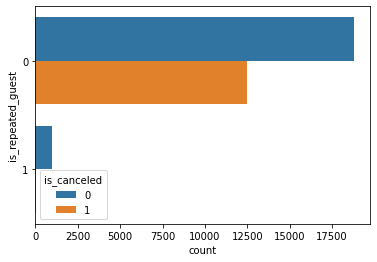

In [723]:
for item in categorical:
    sns.countplot(data = data_test,
                  hue ='is_canceled',
                  y = item)
    plt.show()

In [724]:
numeric = ['adults', 'arrival_date_week_number', 'arrival_date_day_of_month', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time', 'previous_cancellations', 'required_car_parking_spaces', 'total_nights', 'total_of_special_requests']

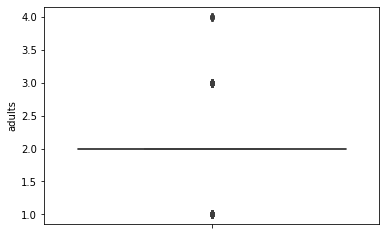

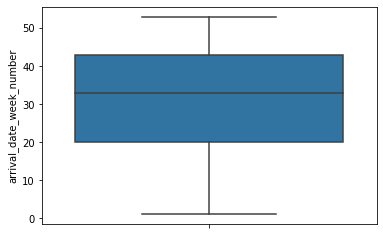

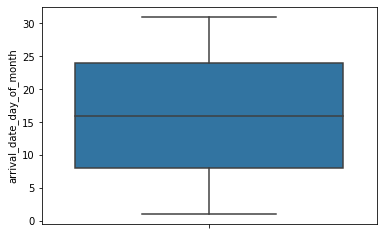

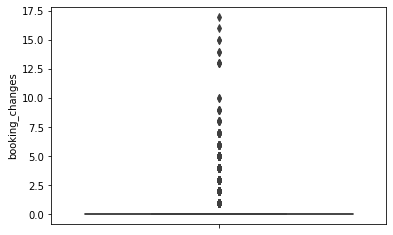

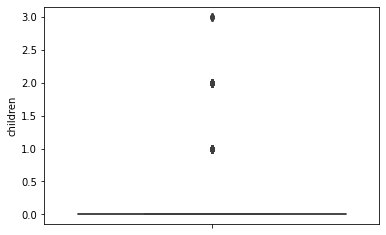

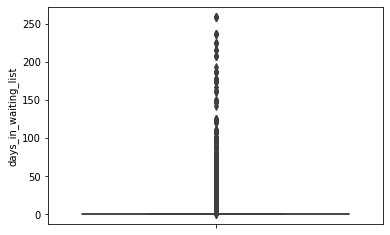

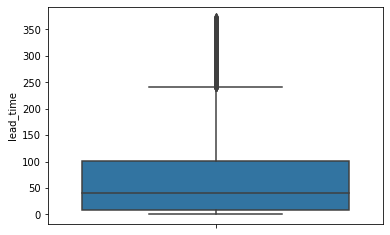

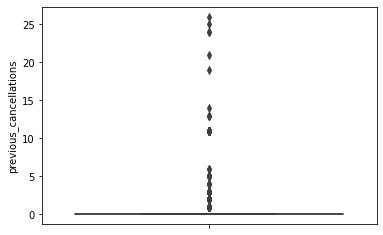

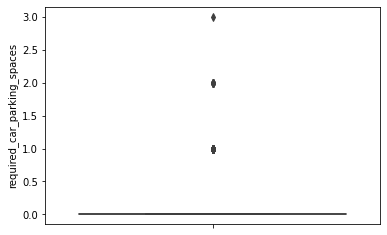

In [725]:
for item in numeric:
    sns.boxplot(data = data_train,
                  y = item)
    plt.show()

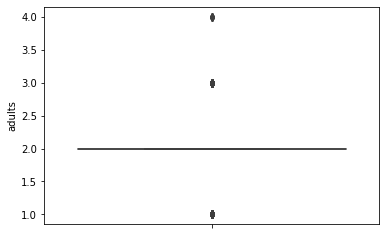

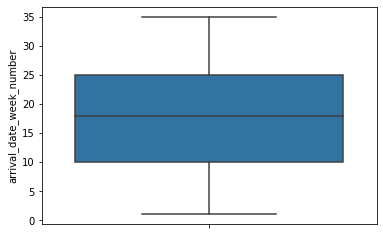

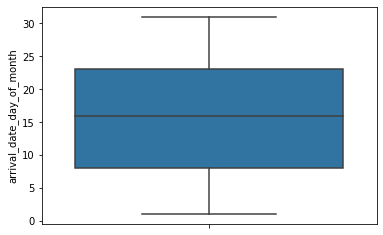

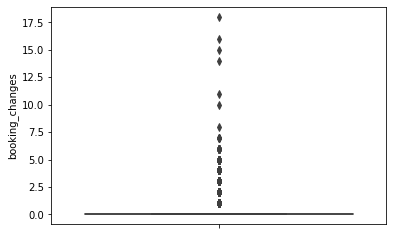

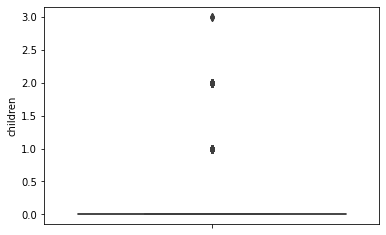

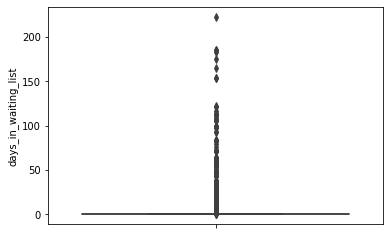

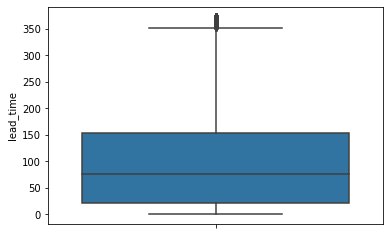

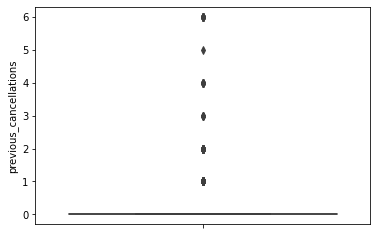

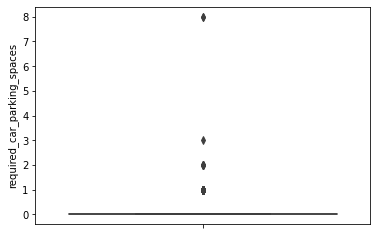

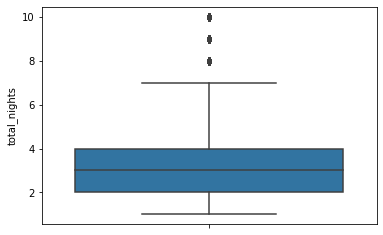

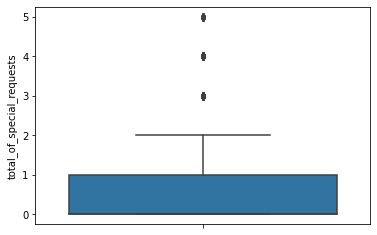

In [726]:
for item in numeric:
    sns.boxplot(data = data_test,
                  y = item)
    plt.show()

В тестовой выборке в колонке `previous_cancellations` не встречаются значения больше 6, в тестовой есть выбросы больше 10, но они не ухудшают обучение модели, поэтому оставляем.

In [727]:
data_train.query('previous_cancellations >= 10')['previous_cancellations'].count()

37

В тестовой выборке в колонке `required_car_parking_spaces` есть значение 8, чего нет в обучающей выборке.

In [728]:
data_test.query('required_car_parking_spaces > 3')

is_canceled  lead_time arrival_date_month  arrival_date_week_number  \
2549            0       26.0              March                        11   
2550            0      138.0              March                        12   

      arrival_date_day_of_month  adults  children  has_babies meal country  \
2549                         14     2.0       0.0         0.0   HB     AUT   
2550                         19     2.0       0.0         0.0   HB     AUT   

     distribution_channel  is_repeated_guest  previous_cancellations  \
2549            Corporate                  1                       0   
2550            Corporate                  1                       0   

     reserved_room_type  booking_changes  days_in_waiting_list  \
2549                  E                1                     0   
2550                  E                1                   122   

        customer_type  required_car_parking_spaces  total_of_special_requests  \
2549  Transient-Party                            8                          1   
2550  Transient-Party                            8                          0   

      total_nights  
2549             5  
2550             4

Всего два таких выброса, но они не влияют на качество обучения модели.

В других колонках тоже есть выбросы, но т.к. в тестовой выборке они так же есть, как и в обучающей, то лучше их оставить.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика - это прибыль отеля. Для начала оценим прибыль отеля без внедрения депозитов.

In [729]:
# словарь со стоимостью номеров и уборки
prices = {
    'A': [1000, 400],
    'B': [800, 350],
    'C': [600, 350],
    'D': [550, 150],
    'E': [500, 150],
    'F': [450, 150],
    'G': [350, 150]
}

# функция расчёта прибыли
def revenue(row):
    
    # по базовому тарифу
    clean_num = 1 + row['total_nights'] // 2
    room_cost = prices[row['reserved_room_type']][0] * row['total_nights']
    cleaning_cost = prices[row['reserved_room_type']][1] * clean_num
    
    # затраты в случае отмены
    if row['is_canceled'] == 1:
        room_cost = -prices[row['reserved_room_type']][0]
        cleaning_cost = prices[row['reserved_room_type']][1]
        
    # надбавки по сезонному коэффициенту
    if ((row['arrival_date_month'] == 'March') or 
    (row['arrival_date_month'] == 'April') or 
    (row['arrival_date_month'] == 'May') or 
    (row['arrival_date_month'] == 'September') or
    (row['arrival_date_month'] == 'October') or
    (row['arrival_date_month'] == 'November')):
        room_cost += room_cost * 0.2
    elif ((row['arrival_date_month'] == 'June') or
    (row['arrival_date_month'] == 'July') or
    (row['arrival_date_month'] == 'August')):
        room_cost += room_cost * 0.4    
    
    return (room_cost - cleaning_cost)

In [730]:
# прибыль отеля до внедрения депозитов на обучающей выборке
rev_before_train = data_train.apply(revenue, axis=1).sum()
print(rev_before_train // 1_000_000, ' млн.')

66.0  млн.


In [731]:
# прибыль отеля до внедрения депозитов на тестовой выборке
rev_before_test = data_test.apply(revenue, axis=1).sum()
print(rev_before_test // 1_000_000, ' млн.')

32.0  млн.


### Шаг 4. Разработка модели ML

Для начала разделим обучающую выборку на признаки и целевой признак.

In [732]:
features_train = data_train.drop(['is_canceled'], axis=1)
target_train = data_train['is_canceled']

В выборке есть много категориальных переменных - закодируем их техникой прямого кодирования для линейной регрессии.

In [733]:
# прямое кодирование категориальных признаков
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
ohe_encoder.fit(features_train[categorical])
features_train_encoded = pd.DataFrame(
    ohe_encoder.transform(features_train[categorical]).toarray(),
    columns=ohe_encoder.get_feature_names(categorical)
)

features_train_ohe = pd.concat((features_train[numeric].reset_index(drop=True), features_train_encoded.reset_index(drop=True)), axis=1)

In [734]:
features_train_ohe

adults  arrival_date_week_number  arrival_date_day_of_month  \
0         1.0                        27                          1   
1         2.0                        27                          1   
2         2.0                        27                          1   
3         2.0                        27                          1   
4         2.0                        27                          1   
...       ...                       ...                        ...   
43562     2.0                        53                         30   
43563     2.0                        53                         31   
43564     2.0                        53                         31   
43565     2.0                        53                         30   
43566     2.0                        53                         31   

       booking_changes  children  days_in_waiting_list  lead_time  \
0                    0       0.0                     0        7.0   
1                    0       0.0                     0       14.0   
2                    0       0.0                     0        0.0   
3                    0       0.0                     0        9.0   
4                    0       0.0                     0       85.0   
...                ...       ...                   ...        ...   
43562                0       0.0                     0       23.0   
43563                0       0.0                     0       53.0   
43564                0       0.0                     0        7.0   
43565                0       0.0                     0       17.0   
43566                0       0.0                     0      107.0   

       previous_cancellations  required_car_parking_spaces  total_nights  ...  \
0                           0                            0             1  ...   
1                           0                            0             2  ...   
2                           0                            0             2  ...   
3                           0                            0             2  ...   
4                           0                            0             3  ...   
...                       ...                          ...           ...  ...   
43562                       0                            0             6  ...   
43563                       0                            0             5  ...   
43564                       0                            0             6  ...   
43565                       0                            0             7  ...   
43566                       0                            0             7  ...   

       reserved_room_type_F  reserved_room_type_G  customer_type_Contract  \
0                       0.0                   0.0                     0.0   
1                       0.0                   0.0                     0.0   
2                       0.0                   0.0                     0.0   
3                       0.0                   0.0                     0.0   
4                       0.0                   0.0                     0.0   
...                     ...                   ...                     ...   
43562                   0.0                   0.0                     0.0   
43563                   0.0                   0.0                     0.0   
43564                   0.0                   0.0                     0.0   
43565                   0.0                   0.0                     0.0   
43566                   0.0                   0.0                     0.0   

       customer_type_Group  customer_type_Transient  \
0                      0.0                      1.0   
1                      0.0                      1.0   
2                      0.0                      1.0   
3                      0.0                      1.0   
4                      0.0                      1.0   
...                    ...                      ...   
43562                  0.0                      1.0   

In [735]:
features_train_ohe.shape

(43567, 77)

In [736]:
target_train.shape

(43567,)

А так же закодируем категориальные признаки техникой порядкового кодирования для решающего дерева и случайного леса.

In [737]:
# порядковое кодирование категориальных признаков
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1)
features_train_ordinal = pd.DataFrame(encoder.fit_transform(features_train), columns=features_train.columns)

In [738]:
features_train_ordinal

lead_time  arrival_date_month  arrival_date_week_number  \
0            7.0                 5.0                      26.0   
1           14.0                 5.0                      26.0   
2            0.0                 5.0                      26.0   
3            9.0                 5.0                      26.0   
4           85.0                 5.0                      26.0   
...          ...                 ...                       ...   
43562       23.0                 2.0                      52.0   
43563       53.0                 2.0                      52.0   
43564        7.0                 2.0                      52.0   
43565       17.0                 2.0                      52.0   
43566      107.0                 2.0                      52.0   

       arrival_date_day_of_month  adults  children  has_babies  meal  country  \
0                            0.0     0.0       0.0         0.0   0.0     13.0   
1                            0.0     1.0       0.0         0.0   0.0     13.0   
2                            0.0     1.0       0.0         0.0   0.0     25.0   
3                            0.0     1.0       0.0         0.0   1.0     25.0   
4                            0.0     1.0       0.0         0.0   0.0     25.0   
...                          ...     ...       ...         ...   ...      ...   
43562                       29.0     1.0       0.0         0.0   0.0      6.0   
43563                       30.0     1.0       0.0         0.0   2.0     12.0   
43564                       30.0     1.0       0.0         0.0   0.0     12.0   
43565                       29.0     1.0       0.0         0.0   3.0     12.0   
43566                       30.0     1.0       0.0         0.0   0.0     12.0   

       distribution_channel  is_repeated_guest  previous_cancellations  \
0                       1.0                0.0                     0.0   
1                       3.0                0.0                     0.0   
2                       1.0                0.0                     0.0   
3                       1.0                0.0                     0.0   
4                       3.0                0.0                     0.0   
...                     ...                ...                     ...   
43562                   3.0                0.0                     0.0   
43563                   3.0                0.0                     0.0   
43564                   3.0                0.0                     0.0   
43565                   3.0                0.0                     0.0   
43566                   3.0                0.0                     0.0   

       reserved_room_type  booking_changes  days_in_waiting_list  \
0                     0.0              0.0                   0.0   
1                     0.0              0.0                   0.0   
2                     2.0              0.0                   0.0   
3                     2.0              0.0                   0.0   
4                     0.0              0.0                   0.0   
...                   ...              ...                   ...   
43562                 3.0              0.0                   0.0   
43563                 3.0              0.0                   0.0   
43564                 3.0              0.0                   0.0   
43565                 0.0              0.0                   0.0   
43566                 0.0              0.0                   0.0   

       customer_type  required_car_parking_spaces  total_of_special_requests  \
0                2.0                          0.0                        0.0   
1                2.0                          0.0                        1.0   
2                2.0                          0.0                        0.0   
3                2.0                          0.0                        1.0   
4                2.0                          0.0                        1.0   
...              ...                          ...      

Числовые признаки имеют разный масштаб, поэтому нужно их стандартизировать.

In [739]:
# стандартизация числовых признаков для линейной регрессии
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])

#### Подбор наилучшей модели

Для оценки качества модели будем использовать F1-меру, т.к. она объединяет в себе показатели precision и recall. С одной стороны, для нас важно минимизировать количество ложноотрицательных ответов модели: клиентов, которые отменят бронирование, но модель решила, что они заселятся, т.к. в этом случае отель несёт больше всего убытков, а с другой стороны, нужно попытаться  минимизировать количество ложноположительных ответов - клиентов, которые не собирались отменять бронирование, а модель решила, что они все-таки отменят, т.к. в этом случае взятие депозита может отпугнуть потенциальных клиентов.

In [740]:
kf = KFold(n_splits=5, random_state=12345, shuffle=True)

In [741]:
# базовая модель решающего дерева
model_1 = DecisionTreeClassifier(random_state=12345)

In [742]:
# оценка модели на кросс-валидации
scores_1 = cross_val_score(model_1, features_train_ordinal, target_train, cv=kf, scoring='f1')
final_score_1 = scores_1.mean()
print('Средняя оценка качества модели:', final_score_1)

Средняя оценка качества модели: 0.5283699557095304


In [743]:
# подбор гиперпараметров и новая оценка
params_model_1 = {
    'class_weight': ['balanced', None],
    'max_depth': [4, 6, 10, 12, 20],
}

grid_model_1 = GridSearchCV(model_1, param_grid=params_model_1, cv=kf, 
                          scoring='f1').fit(features_train_ordinal, target_train)

grid_model_1.best_score_

0.5967883486841397

In [744]:
# лучшие гиперпараметры решающего дерева
grid_model_1.best_params_

{'class_weight': 'balanced', 'max_depth': 12}

In [745]:
# модель решающего дерева с подобранными гиперпараметрами
model_1 = grid_model_1.best_estimator_

In [746]:
# базовая модель логистической регрессии
model_2 = LogisticRegression(random_state=12345)

In [747]:
# оценка модели на кросс-валидации
scores_2 = cross_val_score(model_2, features_train_ohe, target_train, cv=kf, scoring='f1')
final_score_2 = scores_2.mean()
print('Средняя оценка качества модели:', final_score_2)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Средняя оценка качества модели: 0.46293766386605545


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [748]:
%%time
# подбор гиперпараметров для логистической регрессии и новая оценка
params_model_2 = {
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'lbfgs'],
}

grid_model_2 = GridSearchCV(model_2, param_grid=params_model_2, cv=kf, 
                          scoring='f1').fit(features_train_ohe, target_train)

grid_model_2.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

CPU times: user 32.6 s, sys: 34 s, total: 1min 6s
Wall time: 1min 7s


0.568649536780525

In [749]:
# лучшие гиперпараметры для логистической регрессии
grid_model_2.best_params_

{'class_weight': 'balanced', 'solver': 'liblinear'}

In [750]:
# модель логистической регрессии с подобранными гиперпараметрами
model_2 = grid_model_2.best_estimator_

In [751]:
# базовая модель случайного леса
model_3 = RandomForestClassifier(random_state=12345)

In [752]:
# оценка модели на кросс-валидации
scores_3 = cross_val_score(model_3, features_train_ordinal, target_train, cv=kf, scoring='f1')
final_score_3 = scores_3.mean()
print('Средняя оценка качества модели:', final_score_3)

Средняя оценка качества модели: 0.5970800368580678


In [753]:
%%time
# подбор гиперпараметров для случайного леса и новая оценка
params_model_3 = {
    'n_estimators': [50, 51, 52],
    'max_depth': [20, 21, 22],
    'class_weight': ['balanced', None]
}

grid_model_3 = GridSearchCV(model_3, param_grid=params_model_3, cv=kf, 
                          scoring='f1').fit(features_train_ordinal, target_train)

grid_model_3.best_score_

CPU times: user 2min 20s, sys: 0 ns, total: 2min 20s
Wall time: 2min 21s


0.6368431183976403

In [754]:
# лучшие гиперпараметры для случайного леса
grid_model_3.best_params_

{'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 50}

In [755]:
# модель случайного леса с подобранными гиперпараметрами
model_3 = grid_model_3.best_estimator_

Лучшее качество показала модель случайного леса - её и проверим на тестовой выборке.

#### Обучение наилучшей модели и проверка на тестовой выборке

In [756]:
features_test = data_test.drop(['is_canceled'], axis=1)
target_test = data_test['is_canceled']

In [757]:
# порядковое кодирование категориальных признаков
features_test_ordinal = pd.DataFrame(encoder.transform(features_test), columns=features_test.columns)

In [758]:
model_3.fit(features_train_ordinal, target_train)
predictions = pd.Series(model_3.predict(features_test_ordinal))

In [759]:
target_train.value_counts()

0    32469
1    11098
Name: is_canceled, dtype: int64

In [760]:
predictions.value_counts()

0    22484
1     9859
dtype: int64

In [761]:
f1_score(target_test, predictions)

0.6468620366653285

#### Подсчёт прибыли, которую принесёт модель за тестовый период

В нашем случае тестовый период - это 8 месяцев. Нам известны предсказания и правильные ответы. Соответственно, мы можем определить, насколько модель помогает избежать убытков в случае отмены брони. Если модель не угадала отмену брони, то компания несёт убытки в остальных случаях - оказывается в плюсе.

In [762]:
# добавим колонку с предсказаниями в тестовый набор данных
data_test['predict'] = predictions

In [763]:
data_test.head()

is_canceled  lead_time arrival_date_month  arrival_date_week_number  \
0            1       74.0            January                         1   
1            1       62.0            January                         1   
2            1       62.0            January                         1   
3            1       71.0            January                         1   
4            1      172.0            January                         1   

   arrival_date_day_of_month  adults  children  has_babies meal country  ...  \
0                          1     2.0       0.0         0.0   BB     PRT  ...   
1                          1     2.0       0.0         0.0   BB     AUT  ...   
2                          1     2.0       0.0         0.0   BB     AUT  ...   
3                          1     1.0       0.0         0.0   BB     PRT  ...   
4                          1     2.0       0.0         0.0   BB     BEL  ...   

  is_repeated_guest  previous_cancellations  reserved_room_type  \
0                 0                       0                   A   
1                 0                       0                   A   
2                 0                       0                   A   
3                 0                       0                   A   
4                 0                       0                   A   

  booking_changes  days_in_waiting_list  customer_type  \
0               0                     0      Transient   
1               0                     0      Transient   
2               0                     0      Transient   
3               0                     0      Transient   
4               0                     0      Transient   

  required_car_parking_spaces  total_of_special_requests  total_nights  \
0                           0                          0             1   
1                           0                          1             4   
2                           0                          1             4   
3                           0                          1             4   
4                           0                          0             7   

   predict  
0      0.0  
1      0.0  
2      0.0  
3      1.0  
4      0.0  

[5 rows x 21 columns]

Теперь немного модифицируем функцию подсчёта прибыли так, чтобы она учитывала верность предсказания.

In [764]:
# функция расчёта прибыли с учётом предсказаний модели
def revenue_2(row):
    
    # по базовому тарифу
    if row['is_canceled'] == 0:
        clean_num = 1 + row['total_nights'] // 2
        room_cost = prices[row['reserved_room_type']][0] * row['total_nights']
        cleaning_cost = prices[row['reserved_room_type']][1] * clean_num
        
    elif (row['predict'] == 0) and (row['is_canceled'] == 1):
        clean_num = 1
        room_cost = -prices[row['reserved_room_type']][0]
        cleaning_cost = prices[row['reserved_room_type']][1] * clean_num
        
    elif (row['predict'] == 1) and (row['is_canceled'] == 1):
        clean_num = 1
        room_cost = -prices[row['reserved_room_type']][0] * 0.2
        cleaning_cost = prices[row['reserved_room_type']][1] * clean_num * 0.2
        
    # надбавки по сезонному коэффициенту
    if ((row['arrival_date_month'] == 'March') or 
    (row['arrival_date_month'] == 'April') or 
    (row['arrival_date_month'] == 'May') or 
    (row['arrival_date_month'] == 'September') or
    (row['arrival_date_month'] == 'October') or
    (row['arrival_date_month'] == 'November')):
        room_cost += room_cost * 0.2
    elif ((row['arrival_date_month'] == 'June') or
    (row['arrival_date_month'] == 'July') or
    (row['arrival_date_month'] == 'August')):
        room_cost += room_cost * 0.4    
    
    return (room_cost - cleaning_cost)

In [765]:
data_test.head()

is_canceled  lead_time arrival_date_month  arrival_date_week_number  \
0            1       74.0            January                         1   
1            1       62.0            January                         1   
2            1       62.0            January                         1   
3            1       71.0            January                         1   
4            1      172.0            January                         1   

   arrival_date_day_of_month  adults  children  has_babies meal country  ...  \
0                          1     2.0       0.0         0.0   BB     PRT  ...   
1                          1     2.0       0.0         0.0   BB     AUT  ...   
2                          1     2.0       0.0         0.0   BB     AUT  ...   
3                          1     1.0       0.0         0.0   BB     PRT  ...   
4                          1     2.0       0.0         0.0   BB     BEL  ...   

  is_repeated_guest  previous_cancellations  reserved_room_type  \
0                 0                       0                   A   
1                 0                       0                   A   
2                 0                       0                   A   
3                 0                       0                   A   
4                 0                       0                   A   

  booking_changes  days_in_waiting_list  customer_type  \
0               0                     0      Transient   
1               0                     0      Transient   
2               0                     0      Transient   
3               0                     0      Transient   
4               0                     0      Transient   

  required_car_parking_spaces  total_of_special_requests  total_nights  \
0                           0                          0             1   
1                           0                          1             4   
2                           0                          1             4   
3                           0                          1             4   
4                           0                          0             7   

   predict  
0      0.0  
1      0.0  
2      0.0  
3      1.0  
4      0.0  

[5 rows x 21 columns]

In [766]:
data_test.apply(revenue_2, axis=1)

0       -1400.0
1       -1400.0
2       -1400.0
3        -280.0
4       -1400.0
          ...  
32407    6800.0
32408    8200.0
32409    8200.0
32410    4790.0
32411    8200.0
Length: 32343, dtype: float64

In [767]:
# прибыль отеля после внедрения депозитов на тестовой выборке
rev_after_test = data_test.apply(revenue_2, axis=1).sum()
print(rev_after_test // 1_000_000, ' млн.')

41.0  млн.


А теперь сравним прибыль сети отелей до внедрения и после внедрения модели, заодно вычтем затраты на внедрение модели.

In [768]:
print((rev_after_test - rev_before_test - 400_000) // 1_000_000, 'млн.')

8.0 млн.


#### Вывод

Мы выбрали для обучения модель случайного леса и проверили её на тестовой выборке. F1-мера на тестовой выборке показала результат 0.65.<br>
Затем мы изменили функцию расчёта прибыли так, чтобы она учитывала предсказания модели.<br>
Сравнение прибыли сети отелей до и после внедрения системы с учётом затрат на её внедрение показало, что модель принесла 8 млн. чистой прибыли за тестовый период.<br>
Следовательно, новая система выгодна сети.

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [769]:
unreliable_clients = data_test.query('is_canceled == 1 and predict == 1')
unreliable_clients.head()

is_canceled  lead_time arrival_date_month  arrival_date_week_number  \
3             1       71.0            January                         1   
10            1       31.0            January                         1   
13            1       23.0            January                         1   
22            1      112.0            January                         1   
24            1       93.0            January                         1   

    arrival_date_day_of_month  adults  children  has_babies meal country  ...  \
3                           1     1.0       0.0         0.0   BB     PRT  ...   
10                          2     2.0       2.0         0.0   BB     ESP  ...   
13                          3     2.0       0.0         0.0   HB     ESP  ...   
22                          4     2.0       0.0         0.0   BB     PRT  ...   
24                          5     2.0       0.0         0.0   HB     PRT  ...   

   is_repeated_guest  previous_cancellations  reserved_room_type  \
3                  0                       0                   A   
10                 0                       0                   G   
13                 0                       0                   D   
22                 0                       0                   D   
24                 0                       0                   A   

   booking_changes  days_in_waiting_list  customer_type  \
3                0                     0      Transient   
10               0                     0      Transient   
13               0                     0      Transient   
22               0                     0      Transient   
24               1                     0      Transient   

   required_car_parking_spaces  total_of_special_requests  total_nights  \
3                            0                          1             4   
10                           0                          0             5   
13                           0                          0             2   
22                           0                          2             6   
24                           0                          0             3   

    predict  
3       1.0  
10      1.0  
13      1.0  
22      1.0  
24      1.0  

[5 rows x 21 columns]

In [770]:
# инфо о ненадёжных клиентах
unreliable_clients_profile = pandas_profiling.ProfileReport(unreliable_clients)
unreliable_clients_profile.to_file("unreliable_clients_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [771]:
pandas_profiling.ProfileReport(unreliable_clients)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Портрет ненадёжного клиента**

В целом, распределение значений в общей тестовой выборке и выборке клиентов, отменивших бронь, почти везде идентичное.<br>
Самое яркое отличие показывает колонка `lead_time`.<br>
`lead_time` — количество дней между датой бронирования и датой прибытия.<br>
Среднее: 128 дней. Значение намного больше, чем на общей тестовой выборке (97 дней). Нулевое значение всего одно. Следовательно, отменять бронь больше склонны те, кто бронировал сильно заранее до приезда.<br>
Дата заезда и дни недели, судя по всему, не влияют на отказ от брони.<br>
Итальянцы более склонны к отмене брони.<br>
Корпоративные брони чаще отменяются, чем прямые.<br>
В выборке 8 человек, которые раньше уже бронировали номер. Это менее 1% от общего количества человек, ранее проживавших в отеле. Значит, гости, которые не были раньше в отеле, более склонны отменять бронь.<br>
7 человек раньше уже отменяли бронь. Это почти 4% от общего количества человек, которые раньше отменяли бронь. Значит, чаще отменяют бронь те, кто раньше этого не делал.<br>
42% людей из всех, кто ожидал подтверждения брони более 1 дня, от неё в итоге отказались.<br>
Из всех, кто менял условия брони, лишь 7% отказались от неё. Следовательно, ненадёжные клиенты не склонны к изменению условий.<br>
Специальных отметок у ненадёжных клиентов тоже, как правило, нет. Только у 11% отменивших были специальные отметки.<br>
По сравнению с общей тестовой выборкой количество постояльцев, бронировавших на одну ночь, значительно меньше, остальное распределение одинаково. Так, 12% из всех, кто бронировал отель на одну ночь, отказались от брони.

In [773]:
unreliable_clients.query('is_repeated_guest == 1')['is_repeated_guest'].count() / data_test.query('is_repeated_guest == 1')['is_repeated_guest'].count()

0.007881773399014778

In [774]:
unreliable_clients.query('previous_cancellations == 1')['is_repeated_guest'].count() / data_test.query('previous_cancellations == 1')['is_repeated_guest'].count()

0.036585365853658534

In [775]:
unreliable_clients.query('booking_changes > 0')['is_repeated_guest'].count() / data_test.query('booking_changes > 0')['is_repeated_guest'].count()

0.0738746500107689

In [776]:
unreliable_clients.query('days_in_waiting_list > 0')['is_repeated_guest'].count() / data_test.query('days_in_waiting_list > 0')['is_repeated_guest'].count()

0.423728813559322

In [777]:
unreliable_clients.query('total_of_special_requests > 0')['is_repeated_guest'].count() / data_test.query('total_of_special_requests > 0')['is_repeated_guest'].count()

0.11588125665601703

In [778]:
unreliable_clients.query('total_nights == 1')['is_repeated_guest'].count() / data_test.query('total_nights == 1')['is_repeated_guest'].count()

0.1218841642228739

### Шаг 6. Напишите общий вывод

Для предсказания отмены брони была выбрана и обучена модель случайного дерева. На тестовой выборке она показывает наилучшее значение F1-меры - 0.65.<br>
В результате оценке прибыли, которую принесёт модель, получили, что за тестовый период чистая прибыль составит 8 млн.<br>
    
***Рекомендации для бизнеса:***
- внедрить модель предсказания отказа от брони и депозиты
- вести периодический обзвон клиентов, которые сильно заранее бронируют номера, чтобы иметь возможность раньше узнать об отмене
- уладить сбои с подтверждением брони более, чем через один день. Возможно, наладить подвтерждение брони и на выходных тоже.